# Home Credit Default Risk - Kaggle competition

This notebook will cover basic feature engineering and construction of a base model.

## Initial Setup
#### Import packages

In [58]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Set pandas dataframe display to not hide columns
from IPython.display import display
pd.options.display.max_columns = None

# Modelling libraries
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

%matplotlib inline
plt.style.use('fivethirtyeight')

#### Load datasets from EDA notebook

In [270]:
%store -r app_train
%store -r app_test
%store -r bureau_tgt
%store -r prev_app_tgt

print('Training set shape:',app_train.shape)
print('Test set shape:',app_test.shape)
print('Bureau data shape:',bureau_tgt.shape)
print('Prev applications data shape:',prev_app_tgt.shape)

Training set shape: (307511, 211)
Test set shape: (48744, 210)
Bureau data shape: (1716428, 36)
Prev applications data shape: (1670214, 160)


## Feature Engineering

### Additional features from training set

Ideas for additional features:
- Amount of credit relative to income (AMT_CREDIT/AMT_INCOME_TOTAL)
- Amount of annuity relative to income (AMT_ANNUITY/AMT_INCOME_TOTAL)
- Amount of credit relative to age (AMT_CREDIT/DAYS_BIRTH)
- Length of current employment relative to age (DAYS_EMPLOYED/DAYS_BIRTH)

In [271]:
# None of the created features use an aggregate measure (e.g. mean or sum), so we can combine test and train
# sets to ensure that feature creation is consistent.
app_train['test_set'] = 0
app_test['test_set'] = 1

app_train_test = app_train.append(app_test)

print('Train set shape:', app_train.shape)
print('Test set shape:', app_test.shape)
print('Combined set shape:', app_train_test.shape)

Train set shape: (307511, 211)
Test set shape: (48744, 210)
Combined set shape: (356255, 211)


In [272]:
# Create new features from existing
app_train_test['CREDIT_INCOME'] = app_train_test['AMT_CREDIT']/app_train_test['AMT_INCOME_TOTAL']
app_train_test['ANNUITY_INCOME'] = app_train_test['AMT_ANNUITY']/app_train_test['AMT_INCOME_TOTAL']
app_train_test['CREDIT_AGE'] = app_train_test['AMT_CREDIT']/app_train_test['DAYS_BIRTH']
app_train_test['EMPT_AGE'] = app_train_test['DAYS_EMPLOYED']/app_train_test['DAYS_BIRTH']

print('Combined set shape:', app_train_test.shape)

Combined set shape: (356255, 215)


                CREDIT_INCOME  ANNUITY_INCOME  CREDIT_AGE  EMPT_AGE    TARGET
CREDIT_INCOME        1.000000        0.780018   -0.560864  0.024066 -0.007711
ANNUITY_INCOME       0.780018        1.000000   -0.325936 -0.022392  0.014287
CREDIT_AGE          -0.560864       -0.325936    1.000000 -0.121389  0.002729
EMPT_AGE             0.024066       -0.022392   -0.121389  1.000000 -0.067955
TARGET              -0.007711        0.014287    0.002729 -0.067955  1.000000


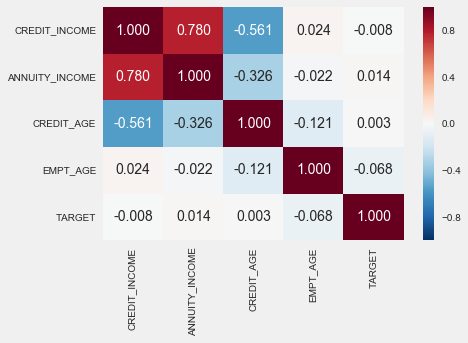

In [273]:
# Check whether these new features are likely to be of interest 
# by computing their correlation with the target variable.
correlations = app_train_test[['CREDIT_INCOME','ANNUITY_INCOME','CREDIT_AGE','EMPT_AGE','TARGET']].corr()
print(correlations)

# Correlation heatmap
sns.heatmap(correlations, annot=True, fmt = ".3f");

It appears as though EMPT_AGE is the only variable that has some relationship with the target variable. 

In [274]:
# Re-separate training and test sets before modelling.
app_train = app_train_test.loc[(app_train_test['test_set']==0),].drop(['test_set'], axis=1)
app_test = app_train_test.loc[(app_train_test['test_set']==1),].drop(['test_set','TARGET'], axis=1)

print('Train set shape:', app_train.shape)
print('Test set shape:', app_test.shape)

Train set shape: (307511, 214)
Test set shape: (48744, 213)


0    1.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: TARGET, dtype: float64


## Baseline Models
### Using training set only

#### Setup

In [60]:
# Set up features and target variables
X = app_train.copy().drop(['TARGET'], axis=1)
X_orig = app_train.copy().drop(['CREDIT_INCOME','ANNUITY_INCOME','CREDIT_AGE','EMPT_AGE','TARGET'], axis=1) # without engineered features
y = app_train['TARGET'].copy()

# Create train and test set splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

#### Logistic regression

Start with basic logistic regression using only features from the training dataset in order to get a baseline.

According to the Kaggle information, the evaluation variable is ROC AUC score.

In [61]:
# Set up pipeline for logistic regression

imp = Imputer(missing_values='NaN', strategy='median', axis=0)

logreg = LogisticRegression()

steps_log = [('imputation', imp),
             ('scaler', StandardScaler()),
             ('logistic_regression', logreg)]

pipeline_log = Pipeline(steps_log)

pipeline_log.fit(X_train, y_train)

Pipeline(steps=[('imputation', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logistic_regression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [62]:
# Make predictions on test dataset
y_pred_log = pipeline_log.predict(X_test)

# Predicted probabilities
y_pred_prob_log = pipeline_log.predict_proba(X_test)[:, 1]

print('Predicted classifications:',y_pred_log[:10])
print('Predicted probabilities:',y_pred_prob_log[:10])

Predicted classifications: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Predicted probabilities: [ 0.23401068  0.02919014  0.15582916  0.01488361  0.08786749  0.19562186
  0.04224744  0.16554878  0.10385714  0.05167467]


In [63]:
# Metrics (competition will be evaluated on ROC AUC score)

# ROC AUC score
print('ROC AUC score:',roc_auc_score(y_test, y_pred_prob_log))

# Accuracy score
print('\nAccuracy score: ',accuracy_score(y_pred_log, y_test))

# Confusion matrix
print('\nConfusion matrix:\n',confusion_matrix(y_test, y_pred_log))

# Classification report
print('\nClassification report:\n',classification_report(y_test, y_pred_log))

ROC AUC score: 0.748029236902

Accuracy score:  0.919451083687

Confusion matrix:
 [[56483    71]
 [ 4883    66]]

Classification report:
              precision    recall  f1-score   support

        0.0       0.92      1.00      0.96     56554
        1.0       0.48      0.01      0.03      4949

avg / total       0.89      0.92      0.88     61503



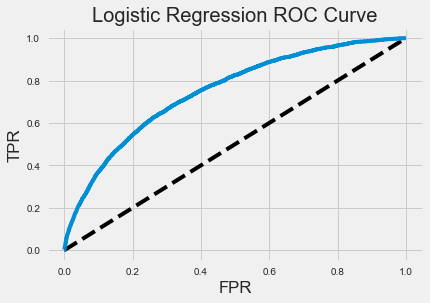

In [64]:
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_log)

plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr,label='Logistic Regression')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Logistic Regression ROC Curve')
plt.show()

In [70]:
cv_scores_log = cross_val_score(pipeline_log, X, y, cv=5, scoring='roc_auc')
print('ROC AUC scores from cross-validation:',cv_scores_log)
print('Mean score:', np.mean(cv_scores_log))

ROC AUC scores from cross-validation: [ 0.74647351  0.74540147  0.74235774  0.74888847  0.7512577 ]
Mean score: 0.746875778367


In [71]:
# Check whether model performs better with or without the added features
cv_scores_log_orig = cross_val_score(pipeline_log, X_orig, y, cv=5, scoring='roc_auc')
print('ROC AUC scores from cross-validation:',cv_scores_log_orig)
print('Mean score:', np.mean(cv_scores_log_orig))

ROC AUC scores from cross-validation: [ 0.74536428  0.74477022  0.74214374  0.7481778   0.75106882]
Mean score: 0.746304971966


The additional features make next to no difference to the model performance. 

#### Random Forest model

In [72]:
# Random forest estimator using 100 trees
random_forest = RandomForestClassifier(n_estimators = 100, random_state=42,verbose=1)

steps_rf = [('imputer', imp),
            ('scaler', StandardScaler()),
            ('random_forest',random_forest)]

pipeline_rf = Pipeline(steps_rf)

pipeline_rf.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  4.0min finished


Pipeline(steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('random_forest', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_feat...timators=100, n_jobs=1, oob_score=False, random_state=42,
            verbose=1, warm_start=False))])

In [73]:
# Make predictions on test dataset
y_pred_rf = pipeline_rf.predict(X_test)

# Predicted probabilities
y_pred_prob_rf = pipeline_rf.predict_proba(X_test)[:, 1]

print('Predicted classifications:',y_pred_rf[:10])
print('Predicted probabilities:',y_pred_prob_rf[:10])

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    5.2s finished


Predicted classifications: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Predicted probabilities: [ 0.22  0.05  0.11  0.05  0.08  0.14  0.04  0.2   0.06  0.05]


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    5.3s finished


In [74]:
# Metrics (competition will be evaluated on ROC AUC score)

# ROC AUC score
print('ROC AUC score:',roc_auc_score(y_test, y_pred_prob_rf))

# Accuracy score
print('\nAccuracy score: ',accuracy_score(y_pred_rf, y_test))

# Confusion matrix
print('\nConfusion matrix:\n',confusion_matrix(y_test, y_pred_rf))

# Classification report
print('\nClassification report:\n',classification_report(y_test, y_pred_rf))

ROC AUC score: 0.714947927359

Accuracy score:  0.919613677382

Confusion matrix:
 [[56552     2]
 [ 4942     7]]

Classification report:
              precision    recall  f1-score   support

        0.0       0.92      1.00      0.96     56554
        1.0       0.78      0.00      0.00      4949

avg / total       0.91      0.92      0.88     61503



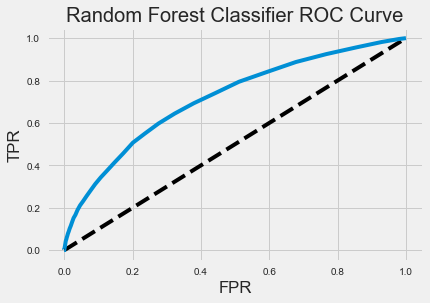

In [75]:
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_rf)

plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr,label='Random Forest Classifier')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Random Forest Classifier ROC Curve')
plt.show()

In [76]:
cv_scores_rf = cross_val_score(pipeline_rf, X, y, cv=5, scoring='roc_auc')
print('ROC AUC scores from cross-validation:', cv_scores_rf)
print('Mean score:', np.mean(cv_scores_rf))

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  3.8min finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    4.7s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  4.0min finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  3.9min finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  3.9min finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    5.6s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  4.1min finished


ROC AUC scores from cross-validation: [ 0.7153475   0.71563951  0.70672647  0.71272529  0.71381824]
Mean score: 0.712851403694


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    4.9s finished


In [78]:
# Do the additional variables make a difference for RF model?
cv_scores_rf_orig = cross_val_score(pipeline_rf, X_orig, y, cv=5, scoring='roc_auc')
print('ROC AUC scores from cross-validation:', cv_scores_rf_orig)
print('Mean score:', np.mean(cv_scores_rf_orig))

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  3.6min finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    5.1s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  3.5min finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    5.1s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  3.4min finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    5.6s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  3.8min finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    5.2s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  3.6min finished


ROC AUC scores from cross-validation: [ 0.71686841  0.71616184  0.71270324  0.71743571  0.71640967]
Mean score: 0.715915776602


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    5.3s finished


The RF model performs slightly better without the additional variables.

## Feature Engineering

### Credit Bureau dataset
Since there can be multiple records in the Bureau dataset per record in the training set, we need to create aggregate information from Bureau before merging into the training set.

Aggregations: (grouped by SK_ID_CURR)
- Count of the number of previous Bureau loans (count of SK_ID_CURR in Bureau)
- Sum of each CREDIT_ACTIVE variables
- Sum of each CREDIT_TYPE variable
- Sum of each of CREDITCURRENCY variables
- Sum of CREDIT_DAY_OVERDUE (so we get the total number of overdue days across all loans the person has)
- Sum of DAYS_CREDIT_ENDDATE (so we get total outstanding length of time across all current (active) Bureau loans. Closed loans have negative DAYS_CREDIT_ENDDATE, so we will only sum across positive values).
- Sum of AMT_CREDIT_SUM_DEBT (current debt on Bureau credit, across all loans)
- Sum of AMT_CREDIT_SUM (current credit amount for the Credit Bureau credit, across all loans)
- Sum of CNT_CREDIT_PROLONG (sum of number of times credit bureau was prolonged across all loans)
- Sum of AMT_CREDIT_SUM_OVERDUE (amoutn of credit overdue across all loans)
- Min of -1 * DAYS_CREDIT (no days before current application that Bureau credit was applied for)
- Min of -1 * DAYS_ENDDATE_FACT (to retrieve tiem since most recently closed loan)
- Min of -1 * DAYS_CREDIT_UPDATE (to capture most recent info)
- Max of AMT_CREDIT_SUM_LIMIT (max credit card limit)

In [364]:
# Create a dataframe aggregated by SK_ID_CURR, which will be later merged into app_train.

# work on a reduced dataset for speed 
#bureau_toagg = bureau_tgt.loc[:1000,].copy()
bureau_toagg = bureau_tgt.copy()
bureau_toagg.drop(['SK_ID_BUREAU','TARGET'], axis =1, inplace=True)

cols_to_max = ['AMT_CREDIT_SUM_LIMIT']
cols_to_min = ['DAYS_CREDIT','DAYS_ENDDATE_FACT','DAYS_CREDIT_UPDATE']
cols_to_sum = [col for col in list(bureau_toagg) if col not in cols_to_max + cols_to_min + ['SK_ID_CURR']]

bureau_toagg[cols_to_min] = -1*bureau_toagg[cols_to_min]
bureau_toagg.loc[(bureau_toagg.DAYS_CREDIT_ENDDATE<0),'DAYS_CREDIT_ENDDATE'] = 0

In [365]:
# Handle missing values before aggregating

# Identify which columns have missing values
def missing_vals_cols(df):
    mv_cols = df.columns[df.isnull().any()].tolist()
    print('Dataframe has {} columns.\nThere are {} columns with missing values.'.format(df.shape[1],len(mv_cols)))
    
    return mv_cols

missing_vals_cols(bureau_toagg)

Dataframe has 34 columns.
There are 5 columns with missing values.


['DAYS_CREDIT_ENDDATE',
 'DAYS_ENDDATE_FACT',
 'AMT_CREDIT_SUM',
 'AMT_CREDIT_SUM_DEBT',
 'AMT_CREDIT_SUM_LIMIT']

In [366]:
# AMT_CREDIT_SUM_LIMIT
# Set missing values to zero, since this variable is only >0 when client has a credit card loan.
# (However, there are some cases where client has an active credit card loan and missing AMT_CREDIT_SUM_LIMIT)
bureau_toagg.loc[(bureau_toagg.AMT_CREDIT_SUM_LIMIT.isnull()),'AMT_CREDIT_SUM_LIMIT'] = 0

In [367]:
# DAYS_ENDDATE_FACT
# Set missing values to zero.
bureau_toagg.loc[(bureau_toagg.DAYS_ENDDATE_FACT.isnull()),'DAYS_ENDDATE_FACT'] = 0

In [368]:
# DAYS_CREDIT_ENDDATE
# If loan is not active, set missing values to zero.
# If loan is active, set missing values to 0.5 * DAYS_CREDIT (i.e. assume client is half-way through paying their loan).
bureau_toagg.loc[(bureau_toagg.DAYS_CREDIT_ENDDATE.isnull()) & (bureau_toagg.CREDIT_ACTIVE_Active==0),
                 'DAYS_CREDIT_ENDDATE'] = 0
bureau_toagg.loc[(bureau_toagg.DAYS_CREDIT_ENDDATE.isnull()) & (bureau_toagg.CREDIT_ACTIVE_Active!=0),
                 'DAYS_CREDIT_ENDDATE'] = 0.5*bureau_toagg.DAYS_CREDIT

In [369]:
# AMT_CREDIT_SUM
# Set equal to 2 * AMT_CREDIT_SUM_DEBT (i.e. assume client is halfway through paying off the loan).
bureau_toagg.loc[(bureau_toagg.AMT_CREDIT_SUM.isnull()),'AMT_CREDIT_SUM'] = 2*bureau_toagg.AMT_CREDIT_SUM_DEBT

In [370]:
# AMT_CREDIT_SUM_DEBT
# If loan is not active, set to 0.
# If loan is active, set to 0.5 * AMT_CREDIT_SUM (i.e. assume client is halfway through paying off the loan)
bureau_toagg.loc[(bureau_toagg.AMT_CREDIT_SUM_DEBT.isnull()),'AMT_CREDIT_SUM_DEBT'] = 0.5*bureau_toagg.AMT_CREDIT_SUM

In [372]:
# Check again for missing values
missing_vals_cols(bureau_toagg);

Dataframe has 34 columns.
There are 0 columns with missing values.


In [374]:
# Aggregation 

# Set up dictionary to define aggregation functions
agg_fn = {cols_to_max[0]: np.max}
for key in cols_to_min:
    agg_fn[key] = np.min
for key in cols_to_sum:
    agg_fn[key] = np.sum

In [375]:
# Created groupby object
bureau_grouped = bureau_toagg.groupby('SK_ID_CURR')
# Create aggregated dataset
agg_bureau = bureau_grouped.agg(agg_fn)
agg_bureau.reset_index(inplace=True)
agg_bureau.head()

,SK_ID_CURR,AMT_CREDIT_SUM_LIMIT,DAYS_CREDIT,DAYS_ENDDATE_FACT,DAYS_CREDIT_UPDATE,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_OVERDUE,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Bad debt,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Sold,CREDIT_CURRENCY_currency 1,CREDIT_CURRENCY_currency 2,CREDIT_CURRENCY_currency 3,CREDIT_CURRENCY_currency 4,CREDIT_TYPE_Another type of loan,CREDIT_TYPE_Car loan,CREDIT_TYPE_Cash loan (non-earmarked),CREDIT_TYPE_Consumer credit,CREDIT_TYPE_Credit card,CREDIT_TYPE_Interbank credit,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for purchase of shares (margin lending),CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mobile operator loan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan
0,100001,0.000,49,0.0,6,0,3091.0,0,1453365.000,596686.5,0.0,3,0,4,0,7,0,0,0,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0
1,100002,31988.565,103,0.0,7,0,978.5,0,865055.565,309447.0,0.0,2,0,6,0,8,0,0,0,0,0,0,4,4,0,0,0,0,0,0,0,0,0,0
2,100003,810000.000,606,0.0,43,0,1216.0,0,1017400.500,0.0,0.0,1,0,3,0,4,0,0,0,0,0,0,2,2,0,0,0,0,0,0,0,0,0,0
3,100004,0.000,408,382.0,382,0,0.0,0,189037.800,0.0,0.0,0,0,2,0,2,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0
4,100005,0.000,62,0.0,11,0,1446.0,0,657126.000,568408.5,0.0,2,0,1,0,3,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0


In [376]:
# Add a column for count of bureau loans per SK_ID_CURR
num_loans = pd.DataFrame(bureau_grouped.size()).reset_index()
num_loans = num_loans.rename(columns={"SKI_ID_CURR": "SK_ID_CURR", 0:"num_bureau_loans"})

agg_bureau = num_loans.merge(agg_bureau,how='inner',on='SK_ID_CURR')
# Add _b suffix to every column for identification after merging with train set
agg_bureau.columns = [str(col) + '_b' for col in agg_bureau.columns]
agg_bureau.rename(columns = {'SK_ID_CURR_b':'SK_ID_CURR'}, inplace=True)
agg_bureau.head(3)

,SK_ID_CURR,num_bureau_loans,AMT_CREDIT_SUM_LIMIT,DAYS_CREDIT,DAYS_ENDDATE_FACT,DAYS_CREDIT_UPDATE,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_OVERDUE,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Bad debt,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Sold,CREDIT_CURRENCY_currency 1,CREDIT_CURRENCY_currency 2,CREDIT_CURRENCY_currency 3,CREDIT_CURRENCY_currency 4,CREDIT_TYPE_Another type of loan,CREDIT_TYPE_Car loan,CREDIT_TYPE_Cash loan (non-earmarked),CREDIT_TYPE_Consumer credit,CREDIT_TYPE_Credit card,CREDIT_TYPE_Interbank credit,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for purchase of shares (margin lending),CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mobile operator loan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan
0,100001,7,0.000,49,0.0,6,0,3091.0,0,1453365.000,596686.5,0.0,3,0,4,0,7,0,0,0,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0
1,100002,8,31988.565,103,0.0,7,0,978.5,0,865055.565,309447.0,0.0,2,0,6,0,8,0,0,0,0,0,0,4,4,0,0,0,0,0,0,0,0,0,0
2,100003,4,810000.000,606,0.0,43,0,1216.0,0,1017400.500,0.0,0.0,1,0,3,0,4,0,0,0,0,0,0,2,2,0,0,0,0,0,0,0,0,0,0


In [377]:
# Left join into training set, using SK_ID_CURR
print('Train set shape before merge:',app_train.shape)
app_train_b = app_train.merge(agg_bureau,how='left',on='SK_ID_CURR')
print('Train set shape after merge:',app_train_b.shape)
app_train_b.head()

Train set shape before merge: (307511, 214)
Train set shape after merge: (307511, 248)


,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,CNT_CHILDREN,CNT_FAM_MEMBERS,CODE_GENDER_F,CODE_GENDER_M,CODE_GENDER_XNA,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_EMPLOYED_outlier_False,DAYS_EMPLOYED_outlier_True,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,DAYS_REGISTRATION,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,FLAG_CONT_MOBILE,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_2,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_EMAIL,FLAG_EMP_PHONE,FLAG_MOBIL,FLAG_OWN_CAR,FLAG_OWN_REALTY,FLAG_PHONE,FLAG_WORK_PHONE,FLOORSMAX_AVG,FLOORSMAX_MEDI,FLOORSMAX_MODE,FONDKAPREMONT_MODE_not specified,FONDKAPREMONT_MODE_org spec account,FONDKAPREMONT_MODE_reg oper account,FONDKAPREMONT_MODE_reg oper spec account,HOUR_APPR_PROCESS_START,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,LIVE_CITY_NOT_WORK_CITY,LIVE_REGION_NOT_WORK_REGION,NAME_CONTRACT_TYPE,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION

In [401]:
# Deal with missing values in the merged dataset

# Missing values in the new columns of the merged dataset (coming from the bureau dataset) 
# indicate that the client did not have a previous loan registered by the Credit Bureau.

# Thus median imputation is not appropriate for these missing values.

missing_vals_cols(app_train_b[list(agg_bureau)]);

app_train_b.fillna(value={x:10*365 for x in ['DAYS_CREDIT','DAYS_ENDDATE_FACT']}, inplace=True)
app_train_b.fillna(value={x:0 for x in list(agg_bureau)}, inplace=True)

missing_vals_cols(app_train_b[list(agg_bureau)]);

Dataframe has 35 columns.
There are 34 columns with missing values.
Dataframe has 35 columns.
There are 0 columns with missing values.


In [403]:
# Check correlation of new variables with the target
correlations = app_train_b[list(agg_bureau)+['TARGET']].corr()['TARGET'].sort_values()

print('Most positive correlations:\n', correlations.tail(5), sep='')
print('\nMost negative correlations:\n', correlations.head(5), sep='')

Most positive correlations:
DAYS_ENDDATE_FACT        0.023306
DAYS_CREDIT_ENDDATE      0.029737
CREDIT_TYPE_Microloan    0.030122
CREDIT_ACTIVE_Active     0.043569
TARGET                   1.000000
Name: TARGET, dtype: float64

Most negative correlations:
CREDIT_ACTIVE_Closed          -0.037233
DAYS_CREDIT_UPDATE            -0.029981
CREDIT_TYPE_Mortgage          -0.023716
CREDIT_TYPE_Car loan          -0.021790
CREDIT_TYPE_Consumer credit   -0.021275
Name: TARGET, dtype: float64


The feature showing the strognest (positive) correlation with default is the indicator for having an active Credit Bureau loan. The reaminder of the variables do not appear to be especially informative.

#### Logistic regression with additional features from bureau dataset

Check whether the additional features from the credit bureau dataset make any difference to model performance. 

In [404]:
# Setup
X = app_train_b.copy().drop(['TARGET'], axis=1)
y = app_train_b['TARGET'].copy()

# Train and test set splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [405]:
# Pipeline for logistic regression
pipeline_log_b = Pipeline(steps_log)
pipeline_log_b.fit(X_train, y_train)

Pipeline(steps=[('imputation', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logistic_regression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [406]:
# Make predictions on test dataset
y_pred_log_b = pipeline_log_b.predict(X_test)

# Predicted probabilities
y_pred_prob_log_b = pipeline_log_b.predict_proba(X_test)[:, 1]

# Metrics: ROC AUC score
print('ROC AUC score:',roc_auc_score(y_test, y_pred_prob_log_b))

ROC AUC score: 0.755101390551


Performance increases only marginally from 0.748 to 0.755 after including variables from the credit bureau dataset. Hopefully we have better luck with the previous applications dataset!

### Previous Applications dataset
Again, we need to create and aggregated dataframe before merging into the training set.

Aggregations: (grouped by SK_ID_CURR)
- Remove SK_ID_PREV
- Count of the number of previous Home Credit (count of SK_ID_CURR in prev_apps)
- Drop rows where FLAG_LAST_APPL_PER_CONTRACT==0 and drop column
- Max RATE_DOWN_PAYMENT
- Max RATE_INTEREST_PRIMARY
- Max RATE_ITNEREST_PRIVELEGED
- Max SELLERPLACE_AREA
- Max CNT_PAYMENT
- Min -1 * DAYS_DECISION
- Min -1 * DAYS_FIRST_DRAWING
- Min -1 * DAYS_FIRST_DUE
- Min -1 * DAYS_LAST_DUE_1st_VERSION
- Min -1 * DAYS_LAST_DUE
- Min -1 * DAYS_TERMINATION
- Sum WEEKDAY_APPR_PROCESS_START
- Sum HOUR_APPR_PROCESS_START
- Sum NAME_CLIENT_TYPE
- Sum AMT_ANNUITY
- Sum AMT_APPLICATION
- Sum AMT_CREDIT
- Sum AMT_DOWN_PAYMENT
- Sum AMT_GOODS_PRICE
- Sum NAME_CONTRACT_TYPE vars
- Sum NFLAG_LAST_APPL_IN_DAY
- Sum NFLAG_MICRO_CASH
- Sum NAME_CASH_LOAN_PURPOSE
- Sum NAME_CONTRACT_STATUS
- Sum NAME_PAYMENT_TYPE
- Sum CODE_REJECT_REASON
- Sum NAME_TYPE_SUITE
- Sum NAME_GOODS_CATEGORY
- Sum NAME_PORTFOLIO
- Sum NAME_PRODUCT_TYPE
- Sum CHANNEL_TYPE
- Sum NAME_SELLER_INDUSTRY
- Sum NAME_YIELD_GROUP
- Sum PRODUCT_COMBINAITON
- Sum NFLAG_INSURED_ON_APPROVAL

In [568]:
# Prepare dataset for aggregation
prev_toagg = prev_app_tgt.copy()

# Drop applications that are not the last application for a given loan
prev_toagg = prev_toagg.loc[(prev_toagg.FLAG_LAST_APPL_PER_CONTRACT!=0)]

# Drop the prev loan id column and TARGET column and FLAG_LAST_APP column
prev_toagg.drop(['SK_ID_PREV','TARGET', 'FLAG_LAST_APPL_PER_CONTRACT'], axis=1, inplace=True)

# Set up columns for different aggregation methods
cols_to_max = ['SELLERPLACE_AREA', 'CNT_PAYMENT']
cols_to_min = ['DAYS_DECISION','DAYS_FIRST_DRAWING','DAYS_FIRST_DUE','DAYS_LAST_DUE_1ST_VERSION','DAYS_LAST_DUE','DAYS_TERMINATION']
cols_to_sum = [col for col in list(prev_toagg) if col not in cols_to_max + cols_to_min + cols_to_mod + ['SK_ID_CURR']]

prev_toagg[cols_to_min] = -1*prev_toagg[cols_to_min]

In [569]:
# Check for missing values
mvals = missing_vals_cols(prev_toagg)

Dataframe has 157 columns.
There are 10 columns with missing values.


In [570]:
# Percentage of missing values in each column
for col in mvals:
    print(col,':', len(prev_toagg.loc[(prev_toagg[col].isnull())])/len(prev_toagg))

AMT_ANNUITY : 0.22400088100477872
AMT_CREDIT : 6.017792204431622e-07
AMT_GOODS_PRICE : 0.22897819693706412
CNT_PAYMENT : 0.22399787210867653
DAYS_FIRST_DRAWING : 0.3999364521143212
DAYS_FIRST_DUE : 0.3999364521143212
DAYS_LAST_DUE_1ST_VERSION : 0.3999364521143212
DAYS_LAST_DUE : 0.3999364521143212
DAYS_TERMINATION : 0.3999364521143212
NFLAG_INSURED_ON_APPROVAL : 0.3999364521143212


In [571]:
# The last six column have exactly the same percetnage of values missing, implying that 
# the missings are generated by some common process. We will deal with these together.

#### Fill with zeroes for now - come back to this later ###

prev_toagg.loc[(prev_toagg.DAYS_FIRST_DRAWING.isnull()),['DAYS_FIRST_DRAWING','DAYS_FIRST_DUE',
                                                         'DAYS_LAST_DUE_1ST_VERSION','DAYS_LAST_DUE',
                                                         'DAYS_TERMINATION','NFLAG_INSURED_ON_APPROVAL']] = 0

In [572]:
# AMT_ANNUITY
# Set to zero if NAME_CONTRACT_STATUS_Approved==0
# Set to AMT_CREDIT/10 (approximate guess - there are only 8 of these cases)
prev_toagg.loc[(prev_toagg.AMT_ANNUITY.isnull()) & (prev_toagg.NAME_CONTRACT_STATUS_Approved==0),'AMT_ANNUITY'] = 0
prev_toagg.loc[(prev_toagg.AMT_ANNUITY.isnull()) & (prev_toagg.NAME_CONTRACT_STATUS_Approved!=0),'AMT_ANNUITY'] = 0.1*prev_toagg.AMT_CREDIT

In [573]:
# AMT_CREDIT
# There is only one record where AMT_CREDIT is null. AMT_APPLICATION is = 0, so we will set AMT_CREDIT also = 0.
prev_toagg.loc[(prev_toagg.AMT_CREDIT.isnull()),'AMT_CREDIT'] = 0

In [574]:
# AMT_GOODS_PRICE
# Only applicable to consumer loans, so replace missing vals with 0 for revolving and cash loans.
# For consumer loans, there are no approved loans, so set these missing values also to zero.
prev_toagg.loc[(prev_toagg.AMT_GOODS_PRICE.isnull()),'AMT_GOODS_PRICE']=0

In [575]:
# CNT_PAYMENT
# All but 4 records with missing CNT_PAYMENT have non-approved contract status. We will set all missing CNT_PAYMENT values to 0.
prev_toagg.loc[(prev_toagg.CNT_PAYMENT.isnull()),'CNT_PAYMENT'] = 0

In [577]:
# Check again for missing vals
missing_vals_cols(prev_toagg);

Dataframe has 157 columns.
There are 0 columns with missing values.


In [579]:
# Aggregation 

# Set up dictionary to define aggregation functions
for key in cols_to_max:
    agg_fn[key] = np.max
for key in cols_to_min:
    agg_fn[key] = np.min
for key in cols_to_sum:
    agg_fn[key] = np.sum

In [592]:
# Created groupby object
prev_grouped = prev_toagg.groupby('SK_ID_CURR')
# Create aggregated dataset
agg_prev = prev_grouped.agg(agg_fn)
agg_prev.reset_index(inplace=True)
agg_prev.head()

,SK_ID_CURR,SELLERPLACE_AREA,DAYS_DECISION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_GOODS_PRICE,NFLAG_LAST_APPL_IN_DAY,NFLAG_INSURED_ON_APPROVAL,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Consumer loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_CONTRACT_TYPE_XNA,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,NAME_CASH_LOAN_PURPOSE_Building a house or an annex,NAME_CASH_LOAN_PURPOSE_Business development,NAME_CASH_LOAN_PURPOSE_Buying a garage,NAME_CASH_LOAN_PURPOSE_Buying a holiday home / land,NAME_CASH_LOAN_PURPOSE_Buying a home,NAME_CASH_LOAN_PURPOSE_Buying a new car,NAME_CASH_LOAN_PURPOSE_Buying a used car,NAME_CASH_LOAN_PURPOSE_Car repairs,NAME_CASH_LOAN_PURPOSE_Education,NAME_CASH_LOAN_PURPOSE_Everyday expenses,NAME_CASH_LOAN_PURPOSE_Furniture,NAME_CASH_LOAN_PURPOSE_Gasification / water supply,NAME_CASH_LOAN_PURPOSE_Hobby,NAME_CASH_LOAN_PURPOSE_Journey,NAME_CASH_LOAN_PURPOSE_Medicine,NAME_CASH_LOAN_PURPOSE_Money for a third person,NAME_CASH_LOAN_PURPOSE_Other,NAME_CASH_LOAN_PURPOSE_Payments on other loans,NAME_CASH_LOAN_PURPOSE_Purchase of electronic equipment,NAME_CASH_LOAN_PURPOSE_Refusal to name the goal,NAME_CASH_LOAN_PURPOSE_Repairs,NAME_CASH_LOAN_PURPOSE_Urgent needs,NAME_CASH_LOAN_PURPOSE_Wedding / gift / holiday,NAME_CASH_LOAN_PURPOSE_XAP,NAME_CASH_LOAN_PURPOSE_XNA,NAME_CONTRACT_STATUS_Approved,NAME_CONTRACT_STATUS_Canceled,NAME_CONTRACT_STATUS_Refused,NAME_CONTRACT_STATUS_Unused offer,NAME_PAYMENT_TYPE_Cash through the bank,NAME_PAYMENT_TYPE_Cashless from the account of the employer,NAME_PAYMENT_TYPE_Non-cash from your account,NAME_PAYMENT_TYPE_XNA,CODE_REJECT_REASON_CLIENT,CODE_REJECT_REASON_HC,CODE_REJECT_REASON_LIMIT,CODE_REJECT_REASON_SCO,CODE_REJECT_REASON_SCOFR,CODE_REJECT_REASON_SYSTEM,CODE_REJECT_REASON_VERIF,CODE_REJECT_REASON_XAP,CODE_REJECT_REASON_XNA,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_CLIENT_TYPE_New,NAME_CLIENT_TYPE_Refreshed,NAME_CLIENT_TYPE_Repeater,NAME_CLIENT_TYPE_XNA,NAME_GOODS_CATEGORY_Additional Service,NAME_GOODS_CATEGORY_Animals,NAME_GOODS_CATEGORY_Audio/Video,NAME_GOODS_CATEGORY_Auto Accessories,NAME_GOODS_CATEGORY_Clothing and Accessories,NAME_GOODS_CATEGORY_Computers,NAME_GOODS_CATEGORY_Construction Materials,NAME_GOODS_CATEGORY_Consumer Electronics,NAME_GOODS_CATEGORY_Direct Sales,NAME_GOODS_CATEGORY_Education,NAME_GOODS_CATEGORY_Fitness,NAME_GOODS_CATEGORY_Furniture,NAME_GOODS_CATEGORY_Gardening,NAME_GOODS_CATEGORY_Homewares,NAME_GOODS_CATEGORY_House Construction,NAME_GOODS_CATEGORY_Insurance,NAME_GOODS_CATEGORY_Jewelry,NAME_GOODS_CATEGORY_Medical Supplies,NAME_GOODS_CATEGORY_Medicine,NAME_GOODS_CATEGORY_Mobile,NAME_GOODS_CATEGORY_Office Appliances,NAME_GOODS_CATEGORY_Other,NAME_GOODS_CATEGORY_Photo / Cinema Equipment,NAME_GOODS_CATEGORY_Sport and Leisure,NAME_GOODS_CATEGORY_Tourism,NAME_GOODS_CATEGORY_Vehicles,NAME_GOODS_CATEGORY_Weapon,NAME_GOODS_CATEGORY_XNA,NAME_PORTFOLIO_Cards,NAME_PORTFOLIO_Cars,NAME_PORTFOLIO_Cash,NAME_PORTFOLIO_POS,NAME_PORTFOLIO_XNA,NAME_PRODUCT_TYPE_XNA,NAME_PRODUCT_TYPE_walk-in,NAME_PRODUCT_TYPE_x-sell,CHANNEL_TYPE_AP+ (Cash loan),CHANNEL_TYPE_Car dealer,CHANNEL_TYPE_Channel of corporate sales,CHANNEL_TYPE_Contact center,CHANNEL_TYPE_Country-wide,CHANNEL_TYPE_Credit and cash offices,CHANNEL_TYPE_Regional / Local,CHANNEL_TYPE_Stone,NAME_SELLER_INDUSTRY_Auto technology,NAME_SELLER_INDUSTRY_Clothing,NAME_SELLER_INDUSTRY_Connectivity,NAME_SELLER_INDUSTRY_Construction,NAME_SELLER_INDUSTRY_Consumer electronics,NAME_SELLER_INDUSTRY_Furniture,NAME_SELLER_INDUSTRY_Industry,NAME_SELLER_INDUSTRY_Jewelry,NAME_SELLER_INDUSTR

In [593]:
# Add a column for count of bureau loans per SK_ID_CURR
num_loans = pd.DataFrame(prev_grouped.size()).reset_index()
num_loans = num_loans.rename(columns={"SK_ID_CURR": "SK_ID_CURR", 0:"num_hc_loans"})

agg_prev = num_loans.merge(agg_prev,how='inner',on='SK_ID_CURR')
# Add _p suffix to every column for identification after merging with train set
agg_prev.columns = [str(col) + '_p' for col in agg_prev.columns]
agg_prev.rename(columns={'SK_ID_CURR_p':'SK_ID_CURR'}, inplace=True)
agg_prev.head(3)

,SK_ID_CURR,num_hc_loans_p,SELLERPLACE_AREA_p,DAYS_DECISION_p,DAYS_FIRST_DRAWING_p,DAYS_FIRST_DUE_p,DAYS_LAST_DUE_1ST_VERSION_p,DAYS_LAST_DUE_p,DAYS_TERMINATION_p,AMT_ANNUITY_p,AMT_APPLICATION_p,AMT_CREDIT_p,AMT_GOODS_PRICE_p,NFLAG_LAST_APPL_IN_DAY_p,NFLAG_INSURED_ON_APPROVAL_p,NAME_CONTRACT_TYPE_Cash loans_p,NAME_CONTRACT_TYPE_Consumer loans_p,NAME_CONTRACT_TYPE_Revolving loans_p,NAME_CONTRACT_TYPE_XNA_p,WEEKDAY_APPR_PROCESS_START_FRIDAY_p,WEEKDAY_APPR_PROCESS_START_MONDAY_p,WEEKDAY_APPR_PROCESS_START_SATURDAY_p,WEEKDAY_APPR_PROCESS_START_SUNDAY_p,WEEKDAY_APPR_PROCESS_START_THURSDAY_p,WEEKDAY_APPR_PROCESS_START_TUESDAY_p,WEEKDAY_APPR_PROCESS_START_WEDNESDAY_p,NAME_CASH_LOAN_PURPOSE_Building a house or an annex_p,NAME_CASH_LOAN_PURPOSE_Business development_p,NAME_CASH_LOAN_PURPOSE_Buying a garage_p,NAME_CASH_LOAN_PURPOSE_Buying a holiday home / land_p,NAME_CASH_LOAN_PURPOSE_Buying a home_p,NAME_CASH_LOAN_PURPOSE_Buying a new car_p,NAME_CASH_LOAN_PURPOSE_Buying a used car_p,NAME_CASH_LOAN_PURPOSE_Car repairs_p,NAME_CASH_LOAN_PURPOSE_Education_p,NAME_CASH_LOAN_PURPOSE_Everyday expenses_p,NAME_CASH_LOAN_PURPOSE_Furniture_p,NAME_CASH_LOAN_PURPOSE_Gasification / water supply_p,NAME_CASH_LOAN_PURPOSE_Hobby_p,NAME_CASH_LOAN_PURPOSE_Journey_p,NAME_CASH_LOAN_PURPOSE_Medicine_p,NAME_CASH_LOAN_PURPOSE_Money for a third person_p,NAME_CASH_LOAN_PURPOSE_Other_p,NAME_CASH_LOAN_PURPOSE_Payments on other loans_p,NAME_CASH_LOAN_PURPOSE_Purchase of electronic equipment_p,NAME_CASH_LOAN_PURPOSE_Refusal to name the goal_p,NAME_CASH_LOAN_PURPOSE_Repairs_p,NAME_CASH_LOAN_PURPOSE_Urgent needs_p,NAME_CASH_LOAN_PURPOSE_Wedding / gift / holiday_p,NAME_CASH_LOAN_PURPOSE_XAP_p,NAME_CASH_LOAN_PURPOSE_XNA_p,NAME_CONTRACT_STATUS_Approved_p,NAME_CONTRACT_STATUS_Canceled_p,NAME_CONTRACT_STATUS_Refused_p,NAME_CONTRACT_STATUS_Unused offer_p,NAME_PAYMENT_TYPE_Cash through the bank_p,NAME_PAYMENT_TYPE_Cashless from the account of the employer_p,NAME_PAYMENT_TYPE_Non-cash from your account_p,NAME_PAYMENT_TYPE_XNA_p,CODE_REJECT_REASON_CLIENT_p,CODE_REJECT_REASON_HC_p,CODE_REJECT_REASON_LIMIT_p,CODE_REJECT_REASON_SCO_p,CODE_REJECT_REASON_SCOFR_p,CODE_REJECT_REASON_SYSTEM_p,CODE_REJECT_REASON_VERIF_p,CODE_REJECT_REASON_XAP_p,CODE_REJECT_REASON_XNA_p,NAME_TYPE_SUITE_Children_p,NAME_TYPE_SUITE_Family_p,NAME_TYPE_SUITE_Group of people_p,NAME_TYPE_SUITE_Other_A_p,NAME_TYPE_SUITE_Other_B_p,"NAME_TYPE_SUITE_Spouse, partner_p",NAME_TYPE_SUITE_Unaccompanied_p,NAME_CLIENT_TYPE_New_p,NAME_CLIENT_TYPE_Refreshed_p,NAME_CLIENT_TYPE_Repeater_p,NAME_CLIENT_TYPE_XNA_p,NAME_GOODS_CATEGORY_Additional Service_p,NAME_GOODS_CATEGORY_Animals_p,NAME_GOODS_CATEGORY_Audio/Video_p,NAME_GOODS_CATEGORY_Auto Accessories_p,NAME_GOODS_CATEGORY_Clothing and Accessories_p,NAME_GOODS_CATEGORY_Computers_p,NAME_GOODS_CATEGORY_Construction Materials_p,NAME_GOODS_CATEGORY_Consumer Electronics_p,NAME_GOODS_CATEGORY_Direct Sales_p,NAME_GOODS_CATEGORY_Education_p,NAME_GOODS_CATEGORY_Fitness_p,NAME_GOODS_CATEGORY_Furniture_p,NAME_GOODS_CATEGORY_Gardening_p,NAME_GOODS_CATEGORY_Homewares_p,NAME_GOODS_CATEGORY_House Construction_p,NAME_GOODS_CATEGORY_Insurance_p,NAME_GOODS_CATEGORY_Jewelry_p,NAME_GOODS_CATEGORY_Medical Supplies_p,NAME_GOODS_CATEGORY_Medicine_p,NAME_GOODS_CATEGORY_Mobile_p,NAME_GOODS_CATEGORY_Office Appliances_p,NAME_GOODS_CATEGORY_Other_p,NAME_GOODS_CATEGORY_Photo / Cinema Equipment_p,NAME_GOODS_CATEGORY_Sport and Leisure_p,NAME_GOODS_CATEGORY_Tourism_p,NAME_GOODS_CATEGORY_Vehicles_p,NAME_GOODS_CATEGORY_Weapon_p,NAME_GOODS_CATEGORY_XNA_p,NAME_PORTFOLIO_Cards_p,NAME_PORTFOLIO_Cars_p,NAME_PORTFOLIO_Cash_p,NAME_PORTFOLIO_POS_p,NAME_PORTFOLIO_XNA_p,NAME_PRODUCT_TYPE_XNA_p,NAME_PRODUCT_TYPE_walk-in_p,NAME_PRODUCT_TYPE_x-sell_p,CHANNEL_TYPE_AP+ (Cash loan)_p,CHANNEL_TYPE_Car dealer_p,CHANNEL_TYPE_Channel of corporate sales_p,CHANNEL_TYPE_Contact center_p,CHANNEL_TYPE_Country-wide_p,CHANNEL_TYPE_Credit and cash offices_p,CHANNEL_TYPE_Regional / Local_p,CHANNEL_TYPE_Stone_p,NAME_SELLER_INDUSTRY_Auto tec

In [594]:
# Left join into training set, using SK_ID_CURR
print('Train set shape before merge:',app_train_b.shape)
app_train_c = app_train_b.merge(agg_prev,how='left',on='SK_ID_CURR')
print('Train set shape after merge:',app_train_c.shape)
app_train_c.head()

Train set shape before merge: (307511, 248)
Train set shape after merge: (307511, 404)


,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,CNT_CHILDREN,CNT_FAM_MEMBERS,CODE_GENDER_F,CODE_GENDER_M,CODE_GENDER_XNA,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_EMPLOYED_outlier_False,DAYS_EMPLOYED_outlier_True,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,DAYS_REGISTRATION,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,FLAG_CONT_MOBILE,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_2,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_EMAIL,FLAG_EMP_PHONE,FLAG_MOBIL,FLAG_OWN_CAR,FLAG_OWN_REALTY,FLAG_PHONE,FLAG_WORK_PHONE,FLOORSMAX_AVG,FLOORSMAX_MEDI,FLOORSMAX_MODE,FONDKAPREMONT_MODE_not specified,FONDKAPREMONT_MODE_org spec account,FONDKAPREMONT_MODE_reg oper account,FONDKAPREMONT_MODE_reg oper spec account,HOUR_APPR_PROCESS_START,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,LIVE_CITY_NOT_WORK_CITY,LIVE_REGION_NOT_WORK_REGION,NAME_CONTRACT_TYPE,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION

In [596]:
# Deal with missing values in the merged dataset

# Missing values in the new columns of the merged dataset indicate that the client
# did not have a previous loan with Home Credit.

missing_vals_cols(app_train_c[list(agg_prev)]);

app_train_c.fillna(value={x:0 for x in list(agg_prev)}, inplace=True)

missing_vals_cols(app_train_c[list(agg_prev)]);

Dataframe has 157 columns.
There are 156 columns with missing values.
Dataframe has 157 columns.
There are 0 columns with missing values.


In [598]:
# Check correlation of new variables with the target
correlations = app_train_c[list(agg_prev)+['TARGET']].corr()['TARGET'].sort_values()

print('Most positive correlations:\n', correlations.tail(10), sep='')
print('\nMost negative correlations:\n', correlations.head(10), sep='')

Most positive correlations:
NAME_PORTFOLIO_Cards_p                      0.043798
NAME_CONTRACT_TYPE_Revolving loans_p        0.047219
CODE_REJECT_REASON_HC_p                     0.047238
NAME_CLIENT_TYPE_New_p                      0.048748
PRODUCT_COMBINATION_Card Street_p           0.049723
CODE_REJECT_REASON_SCOFR_p                  0.055787
NAME_PRODUCT_TYPE_walk-in_p                 0.062802
NAME_CONTRACT_STATUS_Refused_p              0.064969
TARGET                                      1.000000
NAME_GOODS_CATEGORY_House Construction_p         NaN
Name: TARGET, dtype: float64

Most negative correlations:
PRODUCT_COMBINATION_POS industry with interest_p       -0.028131
NAME_GOODS_CATEGORY_Furniture_p                        -0.026800
NAME_YIELD_GROUP_low_normal_p                          -0.024044
NAME_SELLER_INDUSTRY_Furniture_p                       -0.023700
NAME_CONTRACT_STATUS_Approved_p                        -0.023522
NAME_YIELD_GROUP_low_action_p                          -0.0

There appears to be somewhat stronger correlations between the previous applications dataset and the target variable. 

#### Logistic regression with additional features from bureau dataset

Check whether the additional features from the credit bureau dataset make any difference to mdoel performance. 

In [599]:
# Setup
X = app_train_c.copy().drop(['TARGET'], axis=1)
y = app_train_c['TARGET'].copy()

# Train and test set splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [600]:
# Pipeline for logistic regression
pipeline_log_c = Pipeline(steps_log)
pipeline_log_c.fit(X_train, y_train)

Pipeline(steps=[('imputation', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logistic_regression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [601]:
# Make predictions on test dataset
y_pred_log_c = pipeline_log_c.predict(X_test)

# Predicted probabilities
y_pred_prob_log_c = pipeline_log_c.predict_proba(X_test)[:, 1]

# Metrics: ROC AUC score
print('ROC AUC score:',roc_auc_score(y_test, y_pred_prob_log_c))

ROC AUC score: 0.763799564841


#### Save data for transerral to other notebooks

In [602]:
%store app_train
%store app_test
%store bureau_tgt
%store prev_app_tgt

Stored 'app_train' (DataFrame)
Stored 'app_test' (DataFrame)
Stored 'bureau_tgt' (DataFrame)
Stored 'prev_app_tgt' (DataFrame)
